# TP Optimisation II:  A simple neural network 

### Nom(s): 
### Prénom(s): 
### Groupe:

## Useful packages

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Loading of the train and test data

In [2]:
#
# Load train data
#
Xtrain = np.load('train-images.npy')
Xtrain = np.array([x.ravel()/255 for x in Xtrain])
Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1],1)
Ytrain = np.load('train-labels.npy')
targets_train = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytrain:
    v      = np.zeros((10,1))
    v[lab] = 1
    targets_train+=[np.array(v)]

#
# Load test data
#
Xtest        = np.load('t10k-images.npy')
Xtest        = np.array([x.ravel()/255 for x in Xtest])
Xtest        = Xtest.reshape(Xtest.shape[0],Xtest.shape[1],1)
Ytest        = np.load('t10k-labels.npy')
targets_test = []

#
# Convert digits to 10x1 vectors
#
for lab in Ytest:
    v = np.zeros((10,1))
    v[lab]=1
    targets_test+=[np.array(v)]
#
# Outputs
#
print('There are ',Xtrain.shape[0],'images in the train set')
print('There are ',Xtest.shape[0],'images in the test set')

There are  60000 images in the train set
There are  10000 images in the test set


## Definition of the activation function

 The activation function defines the output of a node given a set of inputs. We use the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> function defined by
 
 $$\sigma_{\alpha} : \mathbb{R}^p\rightarrow [0,1]^p, \quad \mbox{ s.t.} \quad[\sigma_{\alpha}(x)]_i=\frac{e^{x_i+\alpha_i}}{\displaystyle{\sum_{j=1}^{p}e^{x_j+\alpha_j}}}\quad \forall i=1:p. $$  


In [3]:
#
# Nonlinear activation function
#
def softmax(x,alpha):
    """
    Softmax unit activation function 
    x    : Numpy array
    alpha: scalar
    """ 
    p = len(x)
    value = np.zeros((p,1))
    for i in range(p):
        value[i] = np.exp(x[i] + alpha[i]) # value[i] = np.exp(x[i] + alpha)
    value = (value/sum(value))
    
    return value

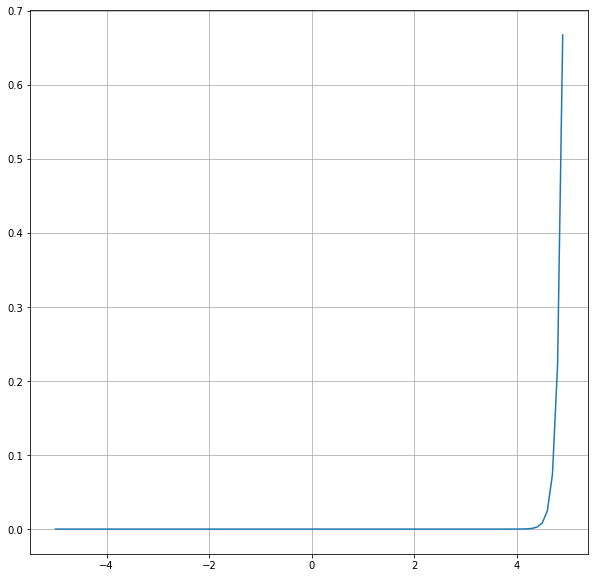

In [4]:
#
# Example of a plot of the activation function
#
t     = np.arange(-5,5,0.1)
alpha = np.arange(-50,50,1)
plt.figure(figsize=(10,10))
plt.plot(t,softmax(t,alpha))
plt.grid(True)
plt.show()


## Definition of a simple neural network

We use a one-layer fully-connected neural network with the <a href="https://en.wikipedia.org/wiki/Softmax_function">softmax</a> activation function.


In [5]:
def NN(x,W):
    """
    # One-layer fully connected neural network
    # x: image, i.e. 784x1 vector (28x28)
    # W: weight matrices of shape 10x784   
    """
    p = W.shape[0]
    prod = W@x
    pred = softmax(prod, np.zeros((p,1)))
    return pred

## Definition of the loss function

The loss function is the <a href="https://en.wikipedia.org/wiki/Cross_entropy">cross-entropy</a> defined by 

$$J(W)=-\sum_{i=1}^N p_i \log(q_i(W)),$$ where $N$ is the number of classes, $(p_i)_{i=1:N}$ are the probabilities of  a data from the training set to belong to a class (0 or 1 because the labels are known), and $(q_i(W))_{i=1:N}$ are the predicted probabilities from the model

$$\forall i=1:N, \quad q_i(W)=[\sigma_{\alpha}(Wx)]_i.$$

In [6]:
#
# Loss function = Cross-entropy
#
def cross_entropy(pred,target,x):
    """
    pred:   predicted probabilities (q(W))
    target: probabilities (p)
    x:      image 
    """ 
    #
    # TO DO: return ce (cross_entropy)
    #
    ce = -sum(np.transpose(target)@np.log(pred))
    #
    # gradient of the cross-entropy
    s = pred
    u    =  np.ones((s.shape[0],1))
    g    = (-u.T.dot(target)*(s.dot(x.T))+target*x.T)
    grad = -g.reshape(x.shape[0]*target.shape[0],1)
    
    return ce,grad
#
# Main function 
#
def f(W,x,target):
    """
    W:      weights
    target: probabilities (p)
    x:      image
    """
    #
    # TO DO: return ce, grad, pred (cross_entropy, gradient, predicted probabilities)
    #
    pred = NN(x,W) 
    ce,grad = cross_entropy(pred,target,x)
    
    return ce,grad,pred

In [7]:
#
# Test information on the gradient with calls of f
#

# Define weight matrices
W      = np.random.rand(10,Xtrain.shape[1])
eps    = 1e-8
d      = np.random.rand(10,Xtrain.shape[1])
Wtilde = W+eps*d

# Retrieve the information on the gradients
res    = (f(Wtilde,Xtrain[0],targets_train[0])[0]-f(W,Xtrain[0],targets_train[0])[0])/eps
print(res)

g      = f(W,Xtrain[0],targets_train[0])[1]
print(g.T.dot(d.reshape(7840,1)))

[2.0309062]
[[2.03090772]]


## Generating batches 

In [ ]:
#
# Function to create batches of samples to be used later in the training phase
#
def create_batches(x,bs):
    """
    x : set to be considered (array)
    bs: batch size (scalar)
    """
    batches = []
    ind     = np.arange(x.shape[0])
    random.shuffle(ind)
    nbatch  = ind.shape[0]//bs
    rest    = ind.shape[0]%bs
    
    for n in range(nbatch):
        batches +=[ind[bs*n:bs*(n+1)]]
    
    # Put the remaining elements in a last batch
    if rest !=0:        
        batches += [ind[-rest:]]
        
    return batches

## Training of the neural network

In [ ]:
history    = {}
eta        = 1e-5 # learning rate
momentum   = 0.   # momemtum factor
N_EPOCHS   = 10  
BatchSizes = [10000,1024,256] # try different batch sizes for the analysis

for bs in BatchSizes:
    #
    # Sensitivity to the batch size to be investigated in the analysis
    #
    print('batch size=',bs)
    
    history[bs]={'train loss':[],'train acc':[],'test loss':[0], 'test acc':[0]}
    
    # Initialization of the weights
    w = np.random.rand(10,Xtrain.shape[1])
    
    for n in range(N_EPOCHS):
        # Minimization of the loss function
        
        Batches=create_batches(Xtrain,bs)
        
        for batch in Batches:
            # Loop on the batches
            ce_sum = 0
            grad_sum = 0
            train_acc = 0
            for i in batch:
                x_t = Xtrain[i]
                target_t = targets_train[i]
                W = w
                ce,grad,pred = f(W,x_t,target_t)
                
                ce_sum += ce
                grad_sum += grad
                
                #on regarde si la prediction vaut bien le label de notre cible
                if (list(pred).index(np.max(pred)) == list(target_t).index(1)):
                    train_acc += 1
                
            history[bs]['train acc'] += [train_acc/batch.shape[0]]
            history[bs]['train loss'] += [ce_sum/batch.shape[0]]
            
            #modication des poids
            sum_grad = grad_sum.reshape(W.shape[0],W.shape[1])
            w = W - eta*sum_grad + momentum*W 
            
                   
        # Test accuracy at the end of each epoch  
        ce_sum_t = 0
        test_acc = 0
        
        for i in range (len(Xtest)):
            target_test = targets_test[i]
            ce,g,pred = f(W,Xtest[i],target_test)
            
            ce_sum_t += ce
            #on regarde si la prediction vaut bien le label de notre cible
            if (list(pred).index(np.max(pred)) == list(target_test).index(1)):
                test_acc += 1
        history[bs]['test acc'] += [test_acc/Xtest.shape[0]]
        history[bs]['test loss'] += [ce_sum_t/Xtest.shape[0]]
            
        
        print('Epoch number :', n+1,'test accuracy:',history[bs]['test acc'][n+1],'test loss',history[bs]['test loss'][n+1])
        

    print('\n')            

## Plots of the evolution of the loss function

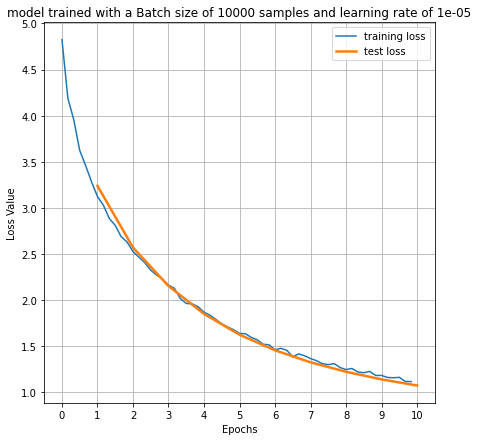

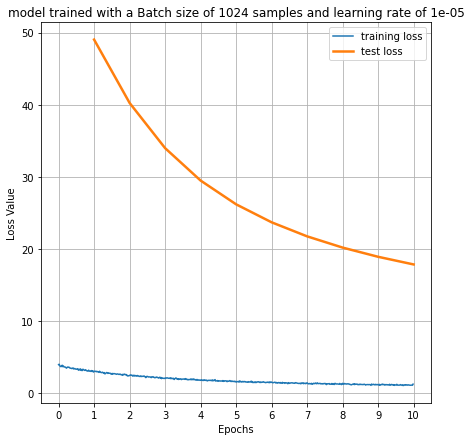

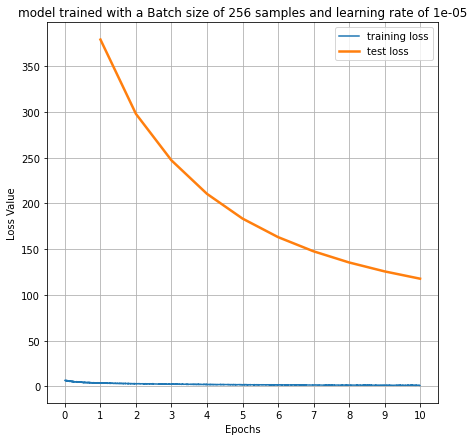

In [10]:
for bs in BatchSizes:
       
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    E  = [n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train loss'],label = 'training loss')
    plt.plot(E[1:],history[bs]['test loss'][1:],linewidth=2.5,label = 'test loss')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Loss Value')
    #plt.ylim([0,np.max(history[bs]['test loss'])+2])
    plt.grid(True)
    plt.legend()
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.show()

## Plots of the evolution of the accuracy

10000
6


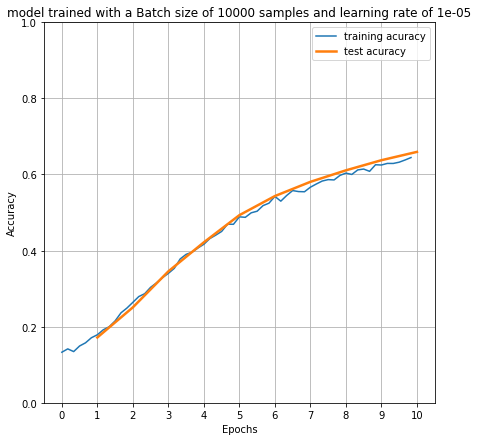

1024
59


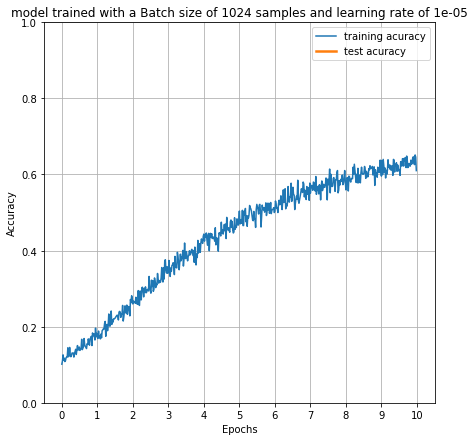

256
235


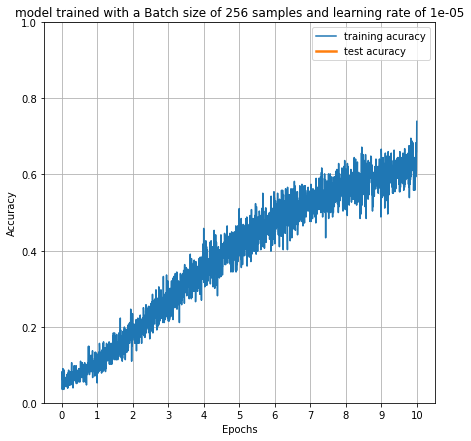

In [11]:
for bs in BatchSizes:
    print(bs)   
    n_batch = Xtrain.shape[0]//bs     
    if Xtrain.shape[0]%bs!=0:
        n_batch+=1
        
    print(n_batch)
    E=[n_batch*n for n in np.arange(N_EPOCHS+1)]
    Ep = [str(n) for n in np.arange(N_EPOCHS+1)]
    
    plt.figure(figsize=(7,7))
    plt.plot(history[bs]['train acc'] ,label  = 'training acuracy')
    plt.plot(E[1:],history[bs]['test acc'][1:],linewidth=2.5,label = 'test acuracy')
    plt.xticks(E,Ep)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.title(f'model trained with a Batch size of {bs} samples and learning rate of {eta}')
    plt.ylim([0,1])
    plt.legend()
    
    plt.show()

## Analysis of the results

Please provide your comments on the sensitivity of the results to the parameters involved in the learning process (batch size, learning rate, momentum).

### Your comments: